#### Copyright 2020 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# XGBoost

[XGBoost](https://github.com/dmlc/xgboost) is a powerful toolkit for performing machine learning tasks. Though much of the current excitement in the machine learning sphere comes from deep learning, XGBoost is a new non-deep-learning algorithm that has won data science competitions and a lot of attention. Instead of a deep neural network, XGBoost uses a collection of decision trees (random forest) arranged and optimized by a boosting scheme and unique penalization of trees in the forest.

XGBoost started becoming popular as it started to perform as well as, if not better than, modern deep learning approaches, while also using less computing resources to train.

## The Dataset

To demonstrate XGBoost, we will use a [subset of data](https://www.kaggle.com/joshmcadams/sdss-16) from the [SDSS data release 16](https://www.sdss.org/dr16/).
This dataset contains data observed about objects in space, as well as the type of object that was observed. We'll see if we can train a model that can classify objects based on these observations.

To get started, upload your `kaggle.json` file and run the code below.

In [ ]:
! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && mv kaggle.json ~/.kaggle/ && echo 'Done'

chmod: cannot access 'kaggle.json': No such file or directory


Next we'll download the `sdss-16` dataset.

In [ ]:
! kaggle datasets download joshmcadams/sdss-16
! ls

sdss-16.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_data  sdss-16.zip


And then load it up and get some information about it. Notice that we use `.info()` to examine the `DataFrame`. The `.info()` method returns information about the data, including column counts and even memory usage.

In [ ]:
import pandas as pd

df = pd.read_csv('sdss-16.zip')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732977 entries, 0 to 732976
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   object_id          732977 non-null  int64  
 1   right_ascension    732977 non-null  float64
 2   declination        732977 non-null  float64
 3   u_magnitude        732977 non-null  float64
 4   g_magnitude        732977 non-null  float64
 5   r_magnitude        732977 non-null  float64
 6   i_magnitude        732977 non-null  float64
 7   z_magnitude        732977 non-null  float64
 8   obs_run_number     732977 non-null  int64  
 9   rerun_number       732977 non-null  int64  
 10  camera_column      732977 non-null  int64  
 11  field_number       732977 non-null  int64  
 12  spectro_object_id  732977 non-null  uint64 
 13  class              732977 non-null  object 
 14  redshift           732977 non-null  float64
 15  plate_id           732977 non-null  int64  
 16  ob

### Exploratory Data Analysis

We can tell from our `.info()` call that we have `732,977` non-null columns. First we should double check that every column is non-null.

In [ ]:
df.isnull().any()

object_id            False
right_ascension      False
declination          False
u_magnitude          False
g_magnitude          False
r_magnitude          False
i_magnitude          False
z_magnitude          False
obs_run_number       False
rerun_number         False
camera_column        False
field_number         False
spectro_object_id    False
class                False
redshift             False
plate_id             False
observation_date     False
fiber_id             False
dtype: bool

Good, no null data. Let's examine the columns that we are working with.

Column | Description
-------|-------------
`object_id`            | Unique SDSS identifier composed from [skyVersion,rerun,run,camcol,field,obj].
`right_ascension`      | J2000 right ascension (r')
`declination`          | J2000 declination (r')
`u_magnitude`          | Model magnitude u-band
`g_magnitude`          | Model magnitude g-band
`r_magnitude`          | Model magnitude r-band
`i_magnitude`          | Model magnitude i-band
`z_magnitude`          | Model magnitude z-band
`obs_run_number`       | Run number
`rerun_number`         | Re-run number
`camera_column`        | Camera column
`field_number`         | Field number
`spectro_object_id`    | Unique ID
`class`                | Type of object (target)
`redshift`             | Final redshift
`plate_id`             | Plate ID
`observation_date`     | Date of observation
`fiber_id`             | Fiber ID

The column that we'll be trying to predict is `class`.

There are quite a few columns that seem to be more metadata than observation data, so we'll not include them in our features. Good candidates for this category include:

* `object_id`
* `obs_run_number`
* `rerun_number`
* `observation_date`
* `spectro_object_id`

Then there are columns that we need to understand better before we can decide whether we should include them or not. These include:

* `camera_column`
* `field_number`
* `plate_id`
* `fiber_id`

Looking at the [SDSS DR16 Glossary](https://www.sdss.org/dr16/help/glossary/), these fields should likely not be used for classification either.

That leaves us with the following potential feature columns:

* `right_ascension`
* `declination`
* `u_magnitude`
* `g_magnitude`
* `r_magnitude`
* `i_magnitude`
* `z_magnitude`
* `redshift`

[Researching more](https://skyserver.sdss.org/dr16/en/proj/advanced/hubble/simple.aspx), it seems that all of these columns are real observations that might be useful to our model.


Now that we know our target and features, let's take a look at them.

First, we'll see how balanced our dataset is.

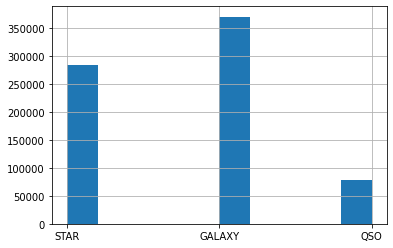

In [ ]:
df['class'].hist()

Not really balanced. We have less than `100,000` quasars and over `350,000` galaxies. We'll need to stratify our testing split for sure.

Let's see how our features are distributed.

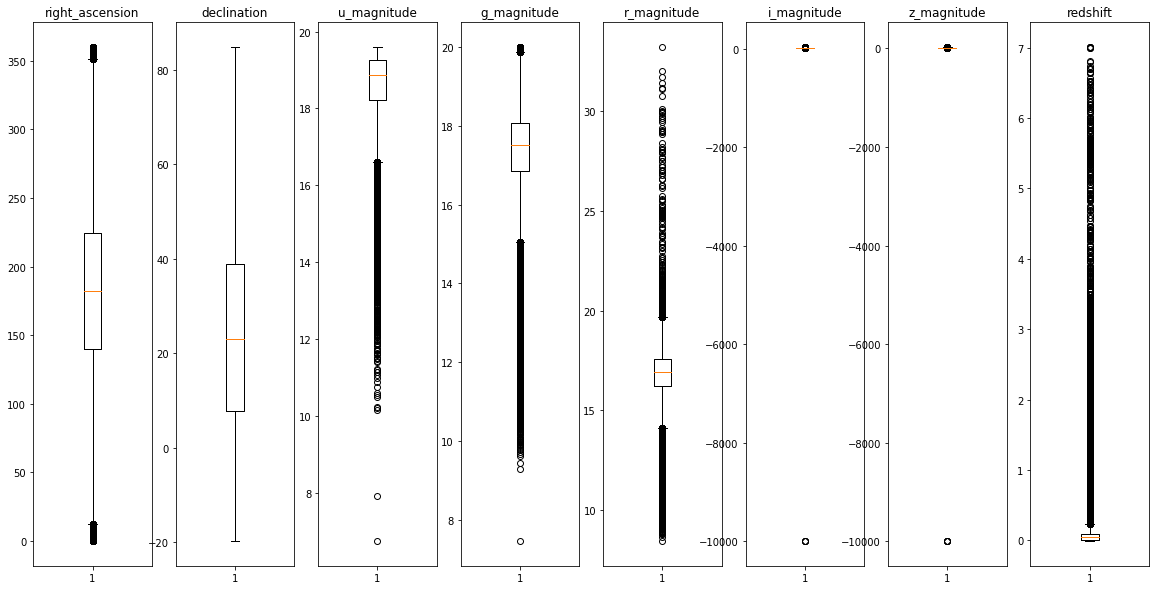

In [ ]:
import matplotlib.pyplot as plt


features = [
  'right_ascension',
  'declination',
  'u_magnitude',
  'g_magnitude',
  'r_magnitude',
  'i_magnitude',
  'z_magnitude',
  'redshift',
]

fig, (axs) = plt.subplots(1, 8, figsize=(20, 10))
for i in range(len(features)):
  axs[i].title.set_text(features[i])
  axs[i].boxplot(df[features[i]])


Wow, that is some spread. Ranges vary from single digits (ex: `redshift`) to large negatives (ex: `i_magnitude` and `z_magnitude`). Some values are relatively normally distributed like `declination`, while others are extremely focused with a wide range of outliers like in `redshift` and `u_magnitude`.

Since we'll be using an XGBoost model backed by decision trees, we won't need to normalize this data.

## The Model

### Data Preprocessing

First off, we'll want to convert our target `class` to a numeric value instead of the string values that we currently have. To do that we'll use the [sklearn `LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). This encodes our three classes as the values `0`, `1`, and `2`.

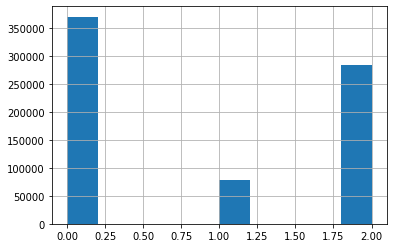

In [ ]:
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
df['encoded_class'] = df[['class']].apply(le.fit_transform)['class']
_ = df['encoded_class'].hist()

We should then split the data, being sure to stratify.

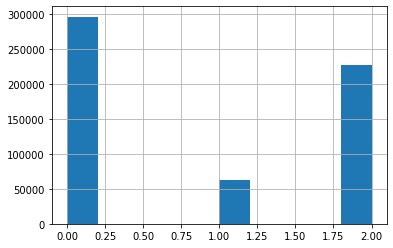

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df['encoded_class'],
    test_size=0.2,
    random_state=8675309,
    shuffle=True,
    stratify=df['encoded_class'])

_ = y_train.hist()

### Building the Model

Now it is time to actually build the model. It is possible to build an XGBoost model in a similar manner as you would a standard scikit-learn model. For example, to create a classifier we can use `XGBClassifer`:

```python
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)
```

*But you will likely regret that decision!*

One of the strengths of XGBoost is its ability to quickly converge on a quality model. In order to do this, we need to set up an input data structure that is optimized for XGBoost processing. This structure is known as the `DMatrix`.

To create a `DMatrix`, we load `xgboost` and pass our testing and training data to the `DMatrix` constructor.

In [ ]:
import xgboost as xgb


d_train = xgb.DMatrix(X_train, y_train)
d_test = xgb.DMatrix(X_test, y_test)

We can now train the model. But what type of model are we training?

In the example above, we asked for an `XGBClassifer`, but with XGBoost you can also pass parameters that determine the type of model being trained. There are numerous [XGBoost parameters](https://xgboost.readthedocs.io/en/latest/parameter.html). One of the most important is the [`objective`](https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters). This tells XGBoost what type of model it should build.

By default, the model is a regression model trained using squared error as a loss. In our case we want a multiclass classification model. Options for building this type of model include `multi:softmax` and `multi:softprob`. We'll go with softmax since it has been used a few times in this course.

There are also model-specific parameters. In our case we chose `multi:softmax`, which requires that we set the number of classes using the `num_class` parameter.

There are general parameters that apply to all models. One of those, `booster`, is set to `gbtree` by default. With a tree booster, there are [specific parameters](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster) that you can set including `max_depth` for the max depth of the trees and `eta` for the learning rate.

Note that we didn't set the number of trees. This is because XGBoost determines the size of the forest using a gradient that eventually converges.

You can probably see that [XGBoost parameters](https://xgboost.readthedocs.io/en/latest/parameter.html) can be pretty complex. One parameter opens up the option for more and more. This is because the `xgboost` class is a wrapper over many different types of models, from classification to regression to ranking. And each of those models has many potential backing algorithms, each with their own parameters.

> *Check your parameters carefully. XGBoost doesn't throw errors when you add useless parameters. Be sure you are using the correct parameters for your current model configuration.*


In [ ]:
import time

params = {
    # What type of model are we building?
    'objective': 'multi:softmax',

    # multi:softmax parameters
    'num_class': 3,

    # General parameters
    'booster': 'gbtree',

    # Tree-specific parameters
    'max_depth': 10, 
    'eta': 0.1,
}

start = time.time()

model = xgb.train(params, d_train)

end = time.time()
print(end - start)

39.94983506202698


We went ahead and timed this training operation just to get a feel for how fast XGBoost is. In our trial run, we trained in just under one minute.

We can now see how well our trained model generalizes.

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

preds = model.predict(d_test)
 
print(np.round(f1_score(y_test, preds, average='micro')*100, 2), '%')

99.31 %


`99.31%`, not bad!

Let's not celebrate too soon. How well does this compare to a vanilla random forest?

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=8675309)

start = time.time()

model.fit(X_train, y_train)

end = time.time()
print(end - start)

preds = model.predict(X_test)

print(np.round(f1_score(y_test, preds, average='micro')*100, 2), '%')

312.46567153930664
99.39 %


Well, that's interesting. The random forest actually did better: `99.39%`, but look at that timing. It took just over around `5` minutes to run in our tests.

There are definitely cases where random forests can out-perform XGBoost, but the cost of training vs. the performance improvement, if it exists, can easily make up for the training time on large datasets.

# Exercises

## Exercise 1: Galaxy or Not Galaxy

In the example above, we tried to determine if an observation was of a star, galaxy, or quasar. The balance of the observations skewed heavily toward galaxies. In this exercise you'll be tasked with using the same [SDSS 16 dataset](https://www.kaggle.com/joshmcadams/sdss-16) and performing a binary classification that determines if an observation is of a galaxy or not.

You'll rely on XGBoost. Your task is to modify the data and the model to perform a binary classification, instead of the multiclass classification shown above.

### **Student Solution**

Using [XGBoost](https://github.com/dmlc/xgboost), create a binary classifier for the [SDSS 16 dataset](https://www.kaggle.com/joshmcadams/sdss-16) that determines if an observation is a galaxy or not.

*Use as many code and text blocks as you need. Explain your work.*

In [ ]:
df['encoded_class'] = (df['encoded_class'] == 0).astype(int)
df.encoded_class.sample(10)

351386    1
601711    0
633652    0
565128    1
701496    1
78993     0
723998    1
479804    0
613761    1
211061    0
Name: encoded_class, dtype: int64

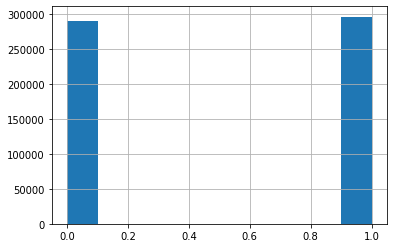

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df['encoded_class'],
    test_size=0.2,
    random_state=8675309,
    shuffle=True,
    stratify=df['encoded_class'])

_ = y_train.hist()

In [ ]:
import xgboost as xgb

d_train = xgb.DMatrix(X_train, y_train)
d_test = xgb.DMatrix(X_test, y_test)

In [ ]:
import time

params = {
    # What type of model are we building?
    'objective': 'binary:logistic',

    # multi:softmax parameters
    # 'num_class': 2,

    # General parameters
    'booster': 'gbtree',

    # Tree-specific parameters
    'max_depth': 10, 
    'eta': 0.1,
}

start = time.time()

model = xgb.train(params, d_train)

end = time.time()
print(end - start)

16.006370067596436


In [ ]:
from sklearn.metrics import f1_score
import numpy as np

predictions = model.predict(d_test)
preds = [int(round(i)) for i in predictions]
 
print(np.round(f1_score(y_test, preds, average='micro')*100, 2), '%')

99.28 %


---